In [12]:
from yahoo_fin import stock_info as si
import pandas as pd
from typing import List
import yfinance as yf
import re


from io import BytesIO, StringIO
import boto3

In [13]:
def create_constant_ticker_df():
    constant_tickers = [
        {"symbol": "ETH-USD", "name": "Ethereum USD", "country": None, "indices": None},
        {"symbol": "BTC-USD", "name": "Bitcoin USD", "country": None, "indices": None},
        {"symbol": "^GSPC", "name": "S&P 500 USD", "country": None, "indices": None},
        {"symbol": "FEZ", "name": "SPDR EURO STOXX 50 ETF USD", "country": None, "indices": None},
        {"symbol": "GC=F", "name": "Gold USD", "country": None, "indices": None},
        {"symbol": "SI=F", "name": "Silver USD", "country": None, "indices": None},
        {"symbol": "EURUSD=X", "name": "EUR USD", "country": None, "indices": None},
        {"symbol": "NOKUSD=X", "name": "Norwegian Crowns USD", "country": None, "indices": None},
        {"symbol": "SEKUSD=X", "name": "Scwedish Crowns USD", "country": None, "indices": None}
    ]

    dfp_constant_tickers = pd.DataFrame(constant_tickers)
    return dfp_constant_tickers

In [14]:
def upload_df_to_S3(df: pd.DataFrame,
                    aws_access_key_id:str,
                    aws_secret_access_key:str,
                    bucket: str,
                    region:str,
                    key: str):

    #csv_buffer = BytesIO()
    csv_buffer = StringIO()
    df.to_csv(csv_buffer, header=True, index=False)
    csv_buffer.seek(0)

    s3_client = boto3.client('s3',
                             aws_access_key_id=aws_access_key_id,
                             aws_secret_access_key=aws_secret_access_key,
                             region_name=region)

    #s3_client.upload_fileobj(csv_buffer, bucket, key)
    s3_client.put_object(Bucket=bucket, Body=csv_buffer.getvalue(), Key=key)
    
    return None

In [15]:
df = create_constant_ticker_df()

In [17]:
s3_key_tickers = "tickers/test.csv"
#s3_bucket='s3://rrrfinance/'
s3_bucket = "rrrfinance"
s3_region='eu-central-1'

upload_df_to_S3(df=df,
                aws_access_key_id= "x",
                aws_secret_access_key="x",
                region=s3_region,
                bucket=s3_bucket,
                key=s3_key_tickers)

# 1. Ticker Symbols from pytickersymbols


python project: https://pypi.org/project/pytickersymbols/

In [163]:
from pytickersymbols import PyTickerSymbols

stock_ticker_symbols = PyTickerSymbols()

smi_tickers = list(stock_ticker_symbols.get_stocks_by_index('SMI'))
dfp_tickers_smi = pd.DataFrame(smi_tickers)

sp100_tickers = list(stock_ticker_symbols.get_stocks_by_index('S&P 500'))
dfp_tickers_sp100 = pd.DataFrame(sp100_tickers)

nasdaq100_tickers = list(stock_ticker_symbols.get_stocks_by_index('NASDAQ 100'))
dfp_tickers_nasdaq100 = pd.DataFrame(nasdaq100_tickers)

dfp_tickers = pd.concat([dfp_tickers_smi,
                         dfp_tickers_sp100,
                         dfp_tickers_nasdaq100])
dfp_tickers = dfp_tickers[dfp_tickers["symbol"].isnull()==False]
dfp_tickers = dfp_tickers.drop_duplicates(["symbol"])
cols = [
    "symbol",
    "name",
    "country",
    "indices"
]
dfp_tickers=dfp_tickers[cols]

dfp_tickers["indices"] = dfp_tickers["indices"].apply(lambda x: ",".join(x))

In [166]:
dfp_tickers.shape

(520, 4)

In [167]:
dfp_tickers.head(5)

,symbol,name,country,indices
0,LIN,Linde PLC,United Kingdom,"DAX,EURO STOXX 50,S&P 100,S&P 500"
1,CCL,Carnival Corporation,United Kingdom,S&P 500
2,SSE,STERIS PLC,United Kingdom,S&P 500
3,MMM,3M Company,United States,"DOW JONES,S&P 100,S&P 500"
4,AXP,American Express Company,United States,"DOW JONES,S&P 100,S&P 500"


In [168]:
tickers = list(dfp_tickers["symbol"].unique())

In [169]:
len(tickers)

520

# 2. Stock Price Data from yfinance

In [181]:
def get_all_stocks_data(tickers: List[str], start_date: str, end_date: str) -> pd.DataFrame:
    """
    Downloads price and volume data from yahoo finance for a list of ticker symbols for a time
    period specified by a start date and end date
    :param tickers: List[str], ticker symbols for which data is downloaded form yahoo finance
    :param start_date: str, format: %Y-%m-%d, the start date
    :param end_date: str, format: %Y-%m-%d, the end date
    :return:
    """
    n_tickers = len(tickers)
    iterations = 2
    step_size = int(n_tickers / iterations-1)

    df_list = []
    for k in range(0, iterations):
        print(k, "of", iterations)
        tickers_tmp = tickers[k:k + step_size]
        if len(tickers_tmp) > 0:
            sep = " "
            tickers_string = sep.join(tickers_tmp)
            df_tmp = yf.download(tickers_string, 
                                 start=start_date, 
                                 end=end_date, 
                                 group_by='ticker', 
                                 interval="1d")
            df_list.append(df_tmp)

    df_time_series = pd.concat(df_list)

    df_list = []
    for ticker in list(df_time_series.columns.levels[0]):
        df_tmp = df_time_series[ticker]
        df_tmp["symbol"] = ticker
        df_tmp = df_tmp[["symbol", "Close", "Volume"]]
        df_list.append(df_tmp)

    df_ts = pd.concat(df_list)
    df_ts = df_ts.reset_index()
    df_ts["Date"] = df_ts["Date"].astype(str)
    df_ts["year"] = df_ts["Date"].str.split("-", expand=True)[0].astype(int)
    df_ts["month"] = df_ts["Date"].str.split("-", expand=True)[1].astype(int)
    df_ts["day"] = df_ts["Date"].str.split("-", expand=True)[2].astype(int)
    df_ts = df_ts.drop(columns= ["Date"])
    df_ts = df_ts.dropna()

    renamed_columns = {
        "Close": "closing_price",
        "Volume": "volume"
    }

    df_ts = df_ts.rename(columns=renamed_columns)
    return df_ts

In [182]:
df_tmp = yf.download("MSFT", start="2021-01-01", 
                     end = "2021-03-01", group_by='ticker', interval="1d")

[*********************100%***********************]  1 of 1 completed


In [183]:
import time
start = time.time()
df2 = get_all_stocks_data(tickers= tickers, start_date="2020-01-01", end_date = "2020-04-01")
end = time.time()
print("time for downloading 3 months of stock data",end-start)

0 of 2
[*********************100%***********************]  259 of 259 completed

3 Failed downloads:
- COG: No data found, symbol may be delisted
- SSE: None
- RTN: No data found, symbol may be delisted
1 of 2
[*********************100%***********************]  259 of 259 completed

3 Failed downloads:
- COG: No data found, symbol may be delisted
- SSE: None
- RTN: No data found, symbol may be delisted


/Users/ralf/opt/anaconda3/envs/nb/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


time for downloading 3 months of stock data 81.17370510101318


In [184]:
df2.shape

(32256, 6)

In [185]:
df2.head(5)

,symbol,closing_price,volume,year,month,day
0,A,85.309998,1176200.0,2019,12,31
1,A,85.949997,1410500.0,2020,1,2
2,A,84.570000,1118300.0,2020,1,3
3,A,84.820000,1993200.0,2020,1,6
4,A,85.080002,1684700.0,2020,1,7


In [186]:
df2.dtypes

symbol            object
closing_price    float64
volume           float64
year               int64
month              int64
day                int64
dtype: object

# 3. Balance Sheet Data From Quandl

In [187]:
path_quandl = "/Users/ralf/Documents/6000_stocks/US_CORE_FINANCIAL_DATA_FULL_HISTORY/SHARADAR_SF1_017f04a0d2ef7cc409f920be72167ada.csv"

In [208]:
df_quandl = pd.read_csv(path_quandl)

cols = ['ticker',
        'dimension',
'reportperiod',
'liabilities',
'debt',
'equity',
'assets',
'marketcap',
'netinc',
'ebit',
'shareswa',
'shareswadil']

df_quandl = df_quandl[cols]
# convert from USD to billion USD
df_quandl["liabilities"] = df_quandl["liabilities"]/1e+09
df_quandl["debt"] = df_quandl["debt"]/1e+09
df_quandl["equity"] = df_quandl["equity"]/1e+09
df_quandl["assets"] = df_quandl["assets"]/1e+09
df_quandl["marketcap"] = df_quandl["marketcap"]/1e+09
df_quandl["netinc"] = df_quandl["netinc"]/1e+09
df_quandl["ebit"] = df_quandl["ebit"]/1e+09
df_quandl["shareswa"] = df_quandl["shareswa"]/1e+09
df_quandl["shareswadil"] = df_quandl["shareswadil"]/1e+09
# calculate additional indicators
df_quandl["earning_yield"] = df_quandl["netinc"]/df_quandl["marketcap"]
df_quandl["rota"] = df_quandl["netinc"]/df_quandl["assets"]
# Add columns for year, month and day
df_quandl["year"] = df_quandl["reportperiod"].str.split("-", expand=True)[0].astype(int)
df_quandl["month"] = df_quandl["reportperiod"].str.split("-", expand=True)[1].astype(int)
df_quandl["day"] = df_quandl["reportperiod"].str.split("-", expand=True)[2].astype(int)


In [ ]:
df_quandl.shape

In [ ]:
df_quandl.dtypes

In [ ]:
df_quandl[df_quandl["ticker"] == "MSFT"]

# 4. M2 Money Supply Data

Data source: https://stats.oecd.org/

In [224]:
path = "/Users/ralf/Documents/6000_stocks/MEI_FIN_20012022224609367.csv"
df_m3 = pd.read_csv(path)

df_m3["year"] = df_m3["TIME"].str.split("-",expand=True)[0]
df_m3["quarter"] = df_m3["TIME"].str.split("-",expand=True)[1]

def replace_none(x):
    if not x:
         return "full_year" 
    else:
        return x
    
df_m3["quarter"] = df_m3["quarter"].apply(replace_none)

cols = [
    "TIME",
    "Value",
    "Country",
    "Frequency"
]

#df_m3 = df_m3[cols]

renamed_columns = {
    "Value": "value",
    "Country": "country",
    "Frequency": "frequency",
}


df_m3 = df_m3.rename(columns=renamed_columns)

In [225]:
df_m3.shape

(1422, 19)

In [226]:
df_m3.head(5)

,SUBJECT,Subject,LOCATION,country,FREQUENCY,frequency,TIME,Time,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,value,Flag Codes,Flags,year,quarter
0,MABM,"Broad Money (M3) Index, SA",USA,United States,A,Annual,1980,1980,IDX,Index,0,Units,2015_100,2015=100,12.78966,NaN,NaN,1980,full_year
1,MABM,"Broad Money (M3) Index, SA",USA,United States,A,Annual,1981,1981,IDX,Index,0,Units,2015_100,2015=100,13.94482,NaN,NaN,1981,full_year
2,MABM,"Broad Money (M3) Index, SA",USA,United States,A,Annual,1982,1982,IDX,Index,0,Units,2015_100,2015=100,15.20398,NaN,NaN,1982,full_year
3,MABM,"Broad Money (M3) Index, SA",USA,United States,A,Annual,1983,1983,IDX,Index,0,Units,2015_100,2015=100,17.06026,NaN,NaN,1983,full_year
4,MABM,"Broad Money (M3) Index, SA",USA,United States,A,Annual,1984,1984,IDX,Index,0,Units,2015_100,2015=100,18.42620,NaN,NaN,1984,full_year


Text(0.5, 0, 'Time (years)')

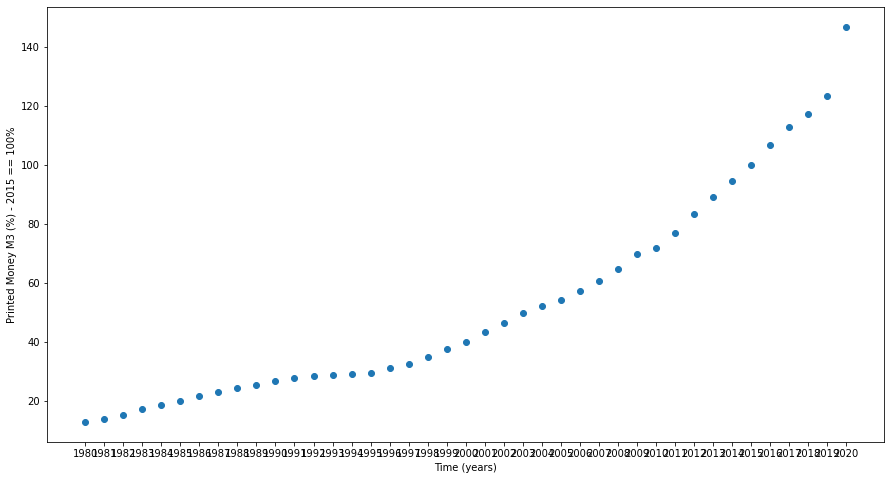

In [213]:
df_tmp = df_m3[df_m3["Country"] == 'United States']
df_tmp = df_tmp[df_tmp["Frequency"] == "Annual"]

import matplotlib.pyplot as plt

plt.figure(figsize = (15,8))
plt.scatter(df_tmp["TIME"],df_tmp["Value"])
plt.ylabel("Printed Money M3 (%) - 2015 == 100%")
plt.xlabel("Time (years)")

Next steps:

stage to s3:

- Ordner struktur und Dateinamen festlegen
- implementieren für tickers und spotprices

>>> import to redshift:

4 tabellen: tickers, spot_prices, fundamentals, m3_money_supply